#Convective Cell Identification & TRAcking (CITRA) using Doppler Weather Radar Images

The cell below installs the Tesseract-OCR model and the Google Drive Mount sequence.

**NOTE**: - When the below cell in run, it pops up a link to request access to your google drive. Open that link and grant acces. Then copy the access code and paste it in the mentioned area in the installation sequence.

In [1]:
!pip install pytesseract
!sudo apt install tesseract-ocr
from google.colab import drive
drive.mount('/content/drive')

  Created wheel for pytesseract: filename=pytesseract-0.3.6-py2.py3-none-any.whl size=13629 sha256=40b057ddd0b75d0816237621104e804e6b46bebd302f8694168c51e6f09ba741
  Stored in directory: /root/.cache/pip/wheels/ee/71/72/b98430261d849ae631e283dfc7ccb456a3fb2ed2205714b63f
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/

In [103]:
"""Convective Cell Identification and Tracking using Doppler Weather Radar Images"""
"""by A Niranjan"""

"""Algorithm for plotting the Convective_System sequence with a folder of consecutive images given as input"""

#Importing the necessary libraries for the project

"""
LIBRARY : USE

1. cv2: OpenSourced Computer Vision Library for image recognition.
2. Numpy: Popular Numerical Python library for various matrix calculations.
3. time: Simulation time analysis.
4. os: OS file handling.
5. pytesseract: An opensource text recognition library for image matrix to string conversions.
6. imutils: Image Utilities for basic image processing functions.
7. contours: Potential area boundary formations.
8. skimage: OpenSource Measure analysis and image recognition Library for segmentation, geometric transformations and color space manipulation.
9. argparse: For passing arguments to the algorithm from terminal.
10. scipy.spatial: Displacement analysis.

"""

import cv2 as cv
import numpy as np
import time,os
import pytesseract
import imutils 
from imutils import contours
from skimage import measure
import argparse
from scipy.spatial import distance
import glob
from google.colab.patches import cv2_imshow


##os.chdir('Your_Data_path_from_Google_Drive')

In [104]:
#Setting the working directory
os.chdir('/content/drive/My Drive/ISRO_Projects/FolderOfImages_ConvectiveCellTracking/20170601/9')

#Setting the path to the tesseract library executable file
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)



In [97]:
#Function for Contour formation with respect to Double Strength bar images.
def formcontour_Double1(x):
    #Initializing Time sequence 
#         start = time.time()

        #Decleration of global variables for image-1 perspective analysis in later functions
        global dresolution_1, Date_1, Time_1, Area_1, cX1, cY1, approx1
        img_main = x

        #Cropping the image with respect to Radar Field in the image
        img_radar = x[43:700,6:722]

        #Convertion of the image into Gray scale and then a blur filter is used to patch the image 
        gray = cv.cvtColor(img_radar, cv.COLOR_BGR2GRAY)
        blurred = cv.GaussianBlur(gray, (11, 11), 0)

        #Thresholding the image for potential area identification
        thresh = cv.threshold(blurred, 200, 255, cv.THRESH_BINARY)[1]
        thresh = cv.erode(thresh, None, iterations=1)
        thresh = cv.dilate(thresh, None, iterations=1)

        #Connected Component Analysis to find the major patch formations
        labels = measure.label(thresh, connectivity = 2, background=0)
        mask = np.zeros(thresh.shape, dtype="uint8")

        # Loop formation over the unique categories
        for label in np.unique(labels):
            # If it were the background label then ignore it
            if label == 0:
                continue

            # Construction of the label mask and determining the total number of pixels in the patches 
            labelMask = np.zeros(thresh.shape, dtype="uint8")
            labelMask[labels == label] = 255
            numPixels = cv.countNonZero(labelMask)


            # Adding the large components to the mask layer if the total number of connected pixels exceed the 150 range
            if numPixels > 150:
                mask = cv.add(mask, labelMask)

        """Implementation of the pytesseract library for text recognition and processing, the pytesseract library can 
        only process images in the RGB Spectrucm, so it is converted from BGR to RGB colour space"""

        Date_1 = pytesseract.image_to_string((cv.cvtColor(img_main[14:39, 3:137],cv.COLOR_BGR2RGB)))
        Time_1 = pytesseract.image_to_string(cv.resize((cv.cvtColor(img_main[14:43, 233:333],cv.COLOR_BGR2RGB)),(150,30)))

        #In few cases the image needs to be resized for better recognition
        #Lattitude and Logitude detection
        lat = pytesseract.image_to_string((cv.resize((cv.cvtColor((img_main[20:39,794:848]),cv.COLOR_BGR2RGB)),(69,25))))
        long = pytesseract.image_to_string((cv.resize((cv.cvtColor((img_main[22:39,863:925]),cv.COLOR_BGR2RGB)),(310,75))))

        #Kilometer per pixel area recognition.
        dresolution_1 =float(pytesseract.image_to_string(cv.resize(((cv.cvtColor((image1[83:100,923:960]),cv.COLOR_BGR2RGB))),(150,70))))


        #Potential area contour formation for displaying the largest patches of the Convective_System
        contours, _=cv.findContours(mask,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        #Storing all the contour areas in one list
        cntArea = [cv.contourArea(c) for c in contours]
        for cnt in contours:

            #Only the largest contour area is considered for plotting
            if(cv.contourArea(cnt) == max(cntArea)):
                epsilon = 0.01*cv.arcLength(cnt,True)

                #Polygonal Structure approximation
                approx1 = cv.approxPolyDP(cnt,epsilon,True)

                #Drawing the contour
                image = cv.drawContours(img_radar,[approx1],0,(0,0,255),2)

                #Total number of pixels enclosed by the contour
                TotalPixels = cv.contourArea(cnt)

                #Area Calculation with respect to the km/pixel value as the image is in a (xx,xx,3) format the values measured are 
                #divided with 30 as the colour spectrum of 3 layers is calculated with respect to kilometer squares.
                Area_1 = ((TotalPixels/30)*dresolution_1)

                #Determining the centroid of the countour
                X = cv.moments(cnt)
                cX1 = int(X["m10"] / X["m00"])
                cY1 = int(X["m01"] / X["m00"])

                #Drawing a line perpendicular from the RADAR to the Contour centroid
                cv.line(img_radar, (int(363), int(329)), (int(cX1), int(cY1)),(0,255,0), 2)

                #Drwing points on the Contour Centroid and the RADAR Origin
                cv.circle(img_radar, (cX1, cY1), 3, (0, 0, 0), -5)
                cv.circle(img_radar, (363,329),3,(0,0,0),-5)

                #Calculating the distance between the Contour Centroid and the RADAR Origin
                D = distance.euclidean((363,329),(cX1,cY1))
                DistanceFromRadar1 = round(D,2)
#                 print('RADAR 1:') 
#                 print('Date : '+ Date_1)
#                 print('Time Stamp : ' + Time_1)
#                 print('Radar Lat&Long: '+lat+" , "+long)
#                 print('Distance From Radar:',round(DistanceFromRadar1*dresolution_1,2), 'km',DirectionOfConvective_System(cX1,cY1))        
#                 print("Total Area Covered is: "+str(round(Area_1,2))+" Km.sq")

#                 #Ending the time sequence
#                 end = time.time()
#                 print(f"Runtime {end - start}")

#                 #Displaying the image
#                 cv.imshow("Result 1",image)
                return 'Successful'


#Function for Radar statistics of double strength bar image-1
def getRadarStats_Double1(x):
    ContourFormation = formcontour_Double1(x)
    if(ContourFormation == 'Successful'):
        return 'Successful'
    else: print('No Convective_System in 1st Image\n')


In [98]:
#Function for Contour formation with respect to Double Strength bar images.
def formcontour_Double2(x):
    #Initializing Time sequence
    start = time.time()
    
    #Decleration of global variables for image-1 perspective analysis in later functions
    global dresolution_2, Date_2, Time_2, Area_2, cX2, cY2,img_radar2
    img_main = x
    
    #Cropping the image with respect to Radar Field in the image
    img_radar2 = x[43:700,6:722]
    
    #Convertion of the image into Gray scale and then a blur filter is used to patch the image 
    gray = cv.cvtColor(img_radar2, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (11, 11), 0)
    
    #Thresholding the image for potential area identification
    thresh = cv.threshold(blurred, 200, 255, cv.THRESH_BINARY)[1]
    thresh = cv.erode(thresh, None, iterations=1)
    thresh = cv.dilate(thresh, None, iterations=1)
    
    #Connected Component Analysis to find the major patch formations
    labels = measure.label(thresh, connectivity = 2, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    # Loop formation over the unique categories
    for label in np.unique(labels):
        
        # If it were the background label then ignore it
        if label == 0:
            continue

        # Construction of the label mask and determining the total number of pixels in the patches 
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv.countNonZero(labelMask)



        # Adding the large components to the mask layer if the total number of connected pixels exceed the 150 range
        if numPixels > 150:
            mask = cv.add(mask, labelMask)
            
    """Implementation of the pytesseract library for text recognition and processing, the pytesseract library can 
    only process images in the RGB Spectrucm, so it is converted from BGR to RGB colour space"""
    
    Date_2 = pytesseract.image_to_string((cv.cvtColor(img_main[14:39, 3:137],cv.COLOR_BGR2RGB)))
    Time_2 = pytesseract.image_to_string(cv.resize((cv.cvtColor(img_main[14:43, 233:333],cv.COLOR_BGR2RGB)),(150,30)))
    
    #In few cases the image needs to be resized for better recognition
    #Lattitude and Logitude detection
    lat = pytesseract.image_to_string((cv.resize((cv.cvtColor((img_main[20:39,794:848]),cv.COLOR_BGR2RGB)),(69,25))))
    long = pytesseract.image_to_string((cv.resize((cv.cvtColor((img_main[22:39,863:925]),cv.COLOR_BGR2RGB)),(310,75))))
    
    #Kilometer per pixel area recognition.
    dresolution_2 =float(pytesseract.image_to_string(cv.resize(((cv.cvtColor((image1[83:100,923:960]),cv.COLOR_BGR2RGB))),(150,70))))
    
    
    #Potential area contour formation for displaying the largest patches of the Convective_System
    contours, _=cv.findContours(mask,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    #Storing all the contour areas in one list
    cntArea = [cv.contourArea(c) for c in contours]
    for cnt in contours:
        
        #Only the largest contour area is considered for plotting
        if(cv.contourArea(cnt) == max(cntArea)):
            epsilon = 0.01*cv.arcLength(cnt,True)
            
            #Polygonal Structure approximation
            approx = cv.approxPolyDP(cnt,epsilon,True)
            
            #Drawing the contour
            img_radar2 = cv.drawContours(img_radar2,[approx],0,(0,0,255),2)
            
            #Total number of pixels enclosed by the contour
            TotalPixels = cv.contourArea(cnt)
            
            #Area Calculation with respect to the km/pixel value as the image is in a (xx,xx,3) format the values measured are 
            #divided with 30 as the colour spectrum of 3 layers is calculated with respect to kilometer squares.
            Area_2 = ((TotalPixels/30)*dresolution_2)
            
            #Determining the centroid of the countour
            X = cv.moments(cnt)
            cX2 = int(X["m10"] / X["m00"])
            cY2 = int(X["m01"] / X["m00"])
            
            #Drawing a line perpendicular from the RADAR to the Contour centroid
            img_radar2 = cv.line(img_radar2, (int(363), int(329)), (int(cX2), int(cY2)),(0,255,0), 2)
            
            #Drwing points on the Contour Centroid and the RADAR Origin
            img_radar2 = cv.circle(img_radar2, (cX2, cY2), 3, (0, 0, 0), -5)
            img_radar2 = cv.circle(img_radar2, (363,329),3,(0,0,0),-5)
            
            #Calculating the distance between the Contour Centroid and the RADAR Origin
            D = distance.euclidean((363,329),(cX2,cY2))
            DistanceFromRadar2 = round(D,2)
            
            #Printing all the necessary details         
#             print('RADAR 2:')
#             print('Date: '+ Date_2)
#             print('Time Stamp: ' + Time_2)
#             print('Radar Lat&Long: '+lat+" , "+long)
#             print('Distance From Radar:',round(DistanceFromRadar2*dresolution_2,2), 'km',DirectionOfConvective_System(cX2,cY2))        
#             print("Total Area Covered is: "+str(round(Area_2,2))+" Km.sq")

#             #Ending the time sequence
#             end = time.time()
#             print(f"Runtime {end - start}")

#             #Ending the time sequence
#             cv.imshow("Result 2",img_radar2)
            return 'Successful'

#Function for Radar statistics of double strength bar image-2
def getRadarStats_Double2(x):
    ContourFormation = formcontour_Double2(x)
    if(ContourFormation == 'Successful'): 
        return 'Successful'
    else: print('No Convective_System in 2nd Image')

In [99]:
#Function for Contour formation with respect to Single Strength bar images.
def formcontour_Single1(x):
    
    #Initializing Time sequence 
    start = time.time()

    #Decleration of global variables for image-1 perspective analysis in later functions
    global dresolution_1, Date_1, Time_1, Area_1, cX1, cY1, approx1
    img_main = x

    #Cropping the image with respect to Radar Field in the image
    img_radar = x[43:752,6:759]

    #Convertion of the image into Gray scale and then a blur filter is used to patch the image 
    gray = cv.cvtColor(img_radar, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (11, 11), 0)

    #Thresholding the image for potential area identification
    thresh = cv.threshold(blurred, 200, 255, cv.THRESH_BINARY)[1]
    thresh = cv.erode(thresh, None, iterations=1)
    thresh = cv.dilate(thresh, None, iterations=1)

    #Connected Component Analysis to find the major patch formations
    labels = measure.label(thresh, connectivity = 2, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    # Loop formation over the unique categories
    for label in np.unique(labels):


        # If it were the background label then ignore it
        if label == 0:
            continue

        # If it were the background label then ignore it 
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv.countNonZero(labelMask)


        # Adding the large components to the mask layer if the total number of connected pixels exceed the 150 range
        if numPixels > 150:
            mask = cv.add(mask, labelMask)


    """Implementation of the pytesseract library for text recognition and processing, the pytesseract library can 
    only process images in the RGB Spectrucm, so it is converted from BGR to RGB colour space"""

    Date_1 = pytesseract.image_to_string((cv.cvtColor(img_main[14:39, 3:137],cv.COLOR_BGR2RGB)))
    Time_1 = pytesseract.image_to_string(cv.resize((cv.cvtColor(img_main[14:43, 233:333],cv.COLOR_BGR2RGB)),(150,30)))

    #In few cases the image needs to be resized for better recognition
    #Lattitude and Logitude detection
    lat = pytesseract.image_to_string((cv.resize((cv.cvtColor((img_main[20:39,794:848]),cv.COLOR_BGR2RGB)),(69,25))))
    long = pytesseract.image_to_string((cv.resize((cv.cvtColor((img_main[22:39,863:925]),cv.COLOR_BGR2RGB)),(310,75))))

    #Kilometer per pixel area recognition.
    dresolution_1 =float(pytesseract.image_to_string(cv.resize(((cv.cvtColor((image1[83:100,923:960]),cv.COLOR_BGR2RGB))),(150,70))))


    #Potential area contour formation for displaying the largest patches of the Convective_System
    contours, _=cv.findContours(mask,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    #Storing all the contour areas in one list
    cntArea = [cv.contourArea(c) for c in contours]
    for cnt in contours:

        #Only the largest contour area is considered for plotting
        if(cv.contourArea(cnt) == max(cntArea)):
            epsilon = 0.01*cv.arcLength(cnt,True)

            #Polygonal Structure approximation
            approx1 = cv.approxPolyDP(cnt,epsilon,True)

            #Drawing the contour
            cv.drawContours(img_radar,[approx1],0,(0,0,255),2)

            #Total number of pixels enclosed by the contour
            TotalPixels = cv.contourArea(cnt)

            #Area Calculation with respect to the km/pixel value as the image is in a (xx,xx,3) format the values measured are 
            #divided with 30 as the colour spectrum of 3 layers is calculated with respect to kilometer squares.
            Area_1 = ((TotalPixels/30)*dresolution_1)

            #Determining the centroid of the countour
            X = cv.moments(cnt)
            cX1 = int(X["m10"] / X["m00"])
            cY1 = int(X["m01"] / X["m00"])

            #Drawing a line perpendicular from the RADAR to the Contour centroid
            cv.line(img_radar, (int(376), int(353)), (int(cX1), int(cY1)),(0,255,0), 2)

            #Drwing points on the Contour Centroid and the RADAR Origin
            cv.circle(img_radar, (cX1, cY1), 3, (0, 0, 0), -5)
            cv.circle(img_radar, (376,353),3,(0,0,0),-5)

            #Calculating the distance between the Contour Centroid and the RADAR Origin
            D = distance.euclidean((363,329),(cX1,cY1))
            DistanceFromRadar = round(D,2)


            #Printing all the necessary details         
#             print('RADAR 1:') 
#             print('Date1: '+ Date_1)
#             print('Time Stamp 1: ' + Time_1)
#             print('Radar Lat&Long: '+lat+" , "+long)
#             print('Distance From Radar:',round(DistanceFromRadar*dresolution_1,2), 'km',DirectionOfConvective_System(cX1,cY1))        
#             print("Total Area Covered is: "+str(round(Area_1,2))+" Km.sq")

#             #Ending the time sequence
#             end = time.time()
#             print(f"Runtime {end - start}")

#             #Displaying the image
#             cv.imshow("Result 1",img_radar)
            return 'Successful'

def getRadarStats_Single1(x):
    ContourFormation = formcontour_Single1(x)
    if(ContourFormation == 'Successful'):
        return 'Successful'
    else: print('No Convective_System in 1st Image\n')



In [100]:
#Function for Contour formation with respect to Single Strength bar images.
def formcontour_Single2(x):
    #Initializing Time sequence
    start = time.time()
    
    #Decleration of global variables for image-1 perspective analysis in later functions
    global dresolution_2, Date_2, Time_2, Area_2, cX2, cY2, img_radar2
    img_main = x
    
    #Decleration of global variables for image-1 perspective analysis in later functions
    img_radar2 = x[43:752,6:759]
    
    #Convertion of the image into Gray scale and then a blur filter is used to patch the image 
    gray = cv.cvtColor(img_radar2, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (11, 11), 0)
    
    #Thresholding the image for potential area identification
    thresh = cv.threshold(blurred, 200, 255, cv.THRESH_BINARY)[1]
    thresh = cv.erode(thresh, None, iterations=1)
    thresh = cv.dilate(thresh, None, iterations=1)
    
    #Connected Component Analysis to find the major patch formations
    labels = measure.label(thresh, connectivity = 2, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    # Loop formation over the unique categories
    for label in np.unique(labels):
        
        # If it were the background label then ignore it
        if label == 0:
            continue

        
        # Construction of the label mask and determining the total number of pixels in the patches
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv.countNonZero(labelMask)



        # Adding the large components to the mask layer if the total number of connected pixels exceed the 150 range
        if numPixels > 150:
            mask = cv.add(mask, labelMask)
            
    """Implementation of the pytesseract library for text recognition and processing, the pytesseract library can 
    only process images in the RGB Spectrucm, so it is converted from BGR to RGB colour space"""
    
    Date_2 = pytesseract.image_to_string((cv.cvtColor(img_main[14:39, 3:137],cv.COLOR_BGR2RGB)))
    Time_2 = pytesseract.image_to_string(cv.resize((cv.cvtColor(img_main[14:43, 233:333],cv.COLOR_BGR2RGB)),(150,30)))
    
    #In few cases the image needs to be resized for better recognition
    #Lattitude and Logitude detection
    lat = pytesseract.image_to_string((cv.resize((cv.cvtColor((img_main[20:39,794:848]),cv.COLOR_BGR2RGB)),(69,25))))
    long = pytesseract.image_to_string((cv.resize((cv.cvtColor((img_main[22:39,863:925]),cv.COLOR_BGR2RGB)),(310,75))))
    
    #Kilometer per pixel area recognition.
    dresolution_2 =float(pytesseract.image_to_string(cv.resize(((cv.cvtColor((image1[83:100,923:960]),cv.COLOR_BGR2RGB))),(150,70))))
    
    #Potential area contour formation for displaying the largest patches of the Convective_System
    contours, _=cv.findContours(mask,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    #Storing all the contour areas in one list
    cntArea = [cv.contourArea(c) for c in contours]
    
    
    for cnt in contours:
        
        #Only the largest contour area is considered for plotting
        if(cv.contourArea(cnt) == max(cntArea)):
            epsilon = 0.01*cv.arcLength(cnt,True)
            
            #Polygonal Structure approximation
            approx = cv.approxPolyDP(cnt,epsilon,True)
            
            #Drawing the contour
            img_radar2 = cv.drawContours(img_radar2,[approx],0,(0,0,255),2)
            
            #Total number of pixels enclosed by the contour
            TotalPixels = cv.contourArea(cnt)
            
            #Area Calculation with respect to the km/pixel value as the image is in a (xx,xx,3) format the values measured are 
            #divided with 30 as the colour spectrum of 3 layers is calculated with respect to kilometer squares.
            Area_2 = ((TotalPixels/30)*dresolution_2)
            
            #Determining the centroid of the countour
            X = cv.moments(cnt)
            cX2 = int(X["m10"] / X["m00"])
            cY2 = int(X["m01"] / X["m00"])
            
            #Drawing a line perpendicular from the RADAR to the Contour centroid
            img_radar2 = cv.line(img_radar2, (int(376), int(353)), (int(cX2), int(cY2)),(0,255,0), 2)
            
            #Drwing points on the Contour Centroid and the RADAR Origin
            img_radar2 = cv.circle(img_radar2, (cX2, cY2), 3, (0, 0, 0), -5)
            img_radar2 = cv.circle(img_radar2, (376,353),3,(0,0,0),-5)
            
            #Calculating the distance between the Contour Centroid and the RADAR Origin
            D = distance.euclidean((363,329),(cX2,cY2))
            DistanceFromRadar = round(D,2)
            
            #Printing all the necessary details  
#             print('RADAR 2:')
#             print('Date2: '+ Date_2)
#             print('Time Stamp 2: ' + Time_2)
#             print('Radar Lat&Long: '+lat+" , "+long)
#             print('Distance From Radar:',round(DistanceFromRadar*dresolution_2,2), 'km',DirectionOfConvective_System(cX2,cY2))        
#             print("Total Area Covered is: "+str(round(Area_2,2))+" Km.sq")

#             #Ending the time sequence
#             end = time.time()
#             print(f"Runtime {end - start}")

#             #Ending the time sequence
#             cv.imshow("Result 2",img_radar2)
            return 'Successful'

#Function for Radar statistics of Single strength bar image-2
def getRadarStats_Single2(x):
    ContourFormation = formcontour_Single2(x)
    if(ContourFormation == 'Successful'): 
        return 'Successful'
    else: print('No Convective_System in 2nd Image')



In [101]:
"""A conditional function to determine the direction of the Convective_System/Potential area
i.e, 0 = North; 90 = East; 180 = South; 270 = West; 360 = North
for the NE, NW, SE, SW detection, the complete radar area is subdivided into 4 Quadrants and then calculated accordingly."""
def DirectionOfConvective_System(x,y):
    if(x == 363 and y < 329): return 'North'
    elif(x >= 358 and x <= 369 and y < 288): return 'North'
    elif(x > 369 and y < 329): return 'North East '
    elif(x > 363 and y == 329): return 'Easy'
    elif(x > 490 and y >= 324 and y <= 334): return 'East'
    elif (x > 363 and y > 334): return 'South East'
    elif(x == 363 and y > 329): return 'South'
    elif(x >= 358 and x <= 369 and y > 500): return 'South'
    elif(x < 358 and y > 334): return 'South West'
    elif(x < 363 and y == 329): return 'West'
    elif(x < 230 and y >= 324 and y <= 334): return 'West'
    elif(x < 358 and y < 334): return 'North West'
    
"""The pytesseract library converts the image matrix into string values, but for time calculation purpose we use the following
function to calculate the total number of seconds by splitting the time string value in to sub divisions as Hours,Mininutes & Seconds"""
def get_sec(time_str):
    
    #Splitting with respect to collon as the time in string is of the form HH:MM:SS
    h, m, s = time_str.split(':')
    
    #Multiplying the respective values with seconds equivalents and returning from the called function 
    return int(h) * 3600 + int(m) * 60 + int(s)



Runtime 5.318078517913818 Seconds


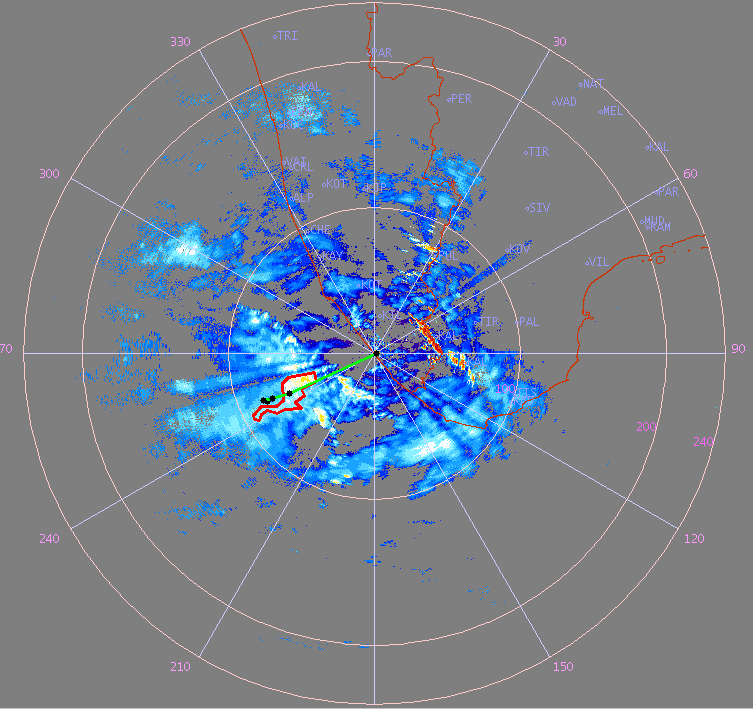

-1

In [102]:
#Combined function for RADAR information determination and tracking.
#In the following function the conditional statements are used to execute various functions depending on the image dimensions.
def FinalRadarStats(image1,image2):
    global radar1_info, radar2_info
    
    if(image1.shape == (770,1078,3)):
        radar1_info = getRadarStats_Single1(image1)
    elif(image1.shape == (720,1082,3)):
        radar1_info = getRadarStats_Double1(image1)
    if(image2.shape == (770,1078,3)):
        radar2_info = getRadarStats_Single2(image2)
    elif(image2.shape == (720,1082,3)):
        radar2_info = getRadarStats_Double2(image2)
    
#Initializing the timer sequence 
start = time.time()

#list to store file names 
file_names = []

#List to store all the Convective_System centroids
Convective_System_centroids = []

#adding all the file names to the list
for i in glob.glob('*.gif*'):
    file_names.append(i)

#Reading all the .gif images in the folder and capturing the images for image processing
for i in range(0,len(file_names)-1):
    gif1 = cv.VideoCapture(file_names[i])
    ret1,image1 = gif1.read()
    gif2 = cv.VideoCapture(file_names[i+1])
    ret2,image2 = gif2.read()
    i += 1

    
    #Calling the main function for image processing
    FinalRadarStats(image1,image2)
    if(radar1_info == 'Successful' and radar2_info == 'Successful'):

        #Determining the time & area difference between the consecutive convective systems from the global variables declared in the functions
        time_difference = round((abs(get_sec(Time_1)-get_sec(Time_2)))/60,2)
        area_difference = round((abs(Area_1 - Area_2)),2)

        #Displacement of the Convective_System
        distance_travelled = round(  (distance.euclidean((cX1,cY1),(cX2,cY2)))*dresolution_2 ,2)

        # The following statement will run if the time difference is less than 70minutes, Area difference is less than 20 km.sq 
        # and displacement less than 100 km.sq
        if(time_difference < 70 and area_difference < 40 and distance_travelled < 100):

            #Drawing relationg between consecutive frames
    #         img_radar2 = cv.drawContours(img_radar2,[approx1],0,(0,255,0),2)
            img_radar2 = cv.line(img_radar2, (int(cX1), int(cY1)), (int(cX2), int(cY2)),(0,255,0), 2)
            img_radar2 = cv.circle(img_radar2, (cX1, cY1), 3, (0, 0, 0), -5)
            img_radar2 = cv.circle(img_radar2, (cX2, cY2), 3, (0, 0, 0), -5)


            #Adding the centroid values to the lists
    #       print('Coordinates1: ','[',cX1,cY1,']','\t','Coordinates2','[',cX2,cY2,']','\n')
            Convective_System_centroids.append([cX1,cY1])
            Convective_System_centroids.append([cX2,cY2])

        else: 
            print("Convective_System could not be traced from ", file_names[i-1],'&',file_names[i])
    else: 
        print('Convective_System correlation not found\n')


#Declaration of the final centroid list to store only exact values which are necessary
final_Convective_System_centroids = []

#Loop to remove duplicates and storing only the consecutive Convective_System centroids
for i in Convective_System_centroids: 
    if i not in final_Convective_System_centroids: 
        final_Convective_System_centroids.append(i)

#Plotting line map to all the consecutive centroids of the Convective_System
for x in range(0,len(final_Convective_System_centroids)-1):
    for y in range(0,1):
        
        #Plotting the path only if the difference in the displacement is less than 40km
        if(  (round((distance.euclidean((int(final_Convective_System_centroids[x][y]),int(final_Convective_System_centroids[x][y+1])),(int(final_Convective_System_centroids[x+1][y]),int(final_Convective_System_centroids[x+1][y+1]) ) )),2)*0.7) < 40 ):

            img_radar2 = cv.line(img_radar2, (int(final_Convective_System_centroids[x][y]), int(final_Convective_System_centroids[x][y+1])), (int(final_Convective_System_centroids[x+1][y]), int(final_Convective_System_centroids[x+1][y+1])),(0,255,0), 2)

            img_radar2 = cv.circle(img_radar2, (final_Convective_System_centroids[x][y], final_Convective_System_centroids[x][y+1]), 3, (0, 0, 0), -5)

            img_radar2 = cv.circle(img_radar2, (final_Convective_System_centroids[x+1][y], final_Convective_System_centroids[x+1][y+1]), 3, (0, 0, 0), -5)

#Ending the time sequence
end = time.time()
print(f"Runtime {end - start} Seconds")

#Displaying the traced Convective_System 
cv2_imshow(img_radar2)
cv.waitKey(0)

# """Writing the final plotted image to the destination file. It is going to be the same directory from which images are given as input to the algorithm"""
# cv.imwrite(args['folder']+'\TestResult.jpeg',img_radar2)